<a id='sec0'></a>
# Predictive annotation of quantification methods 6
Idea is to use the descriptive text for each dataset to predict which quantification method was used for the experiments for the dataset. Below is an outline for the process.<br>
- <a href='#sec4'><b>Classification for label_free</b></a>

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import gensim
from gensim import corpora, models
from gensim import matutils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        average_precision_score, f1_score,
        brier_score_loss, classification_report,
        precision_recall_curve, roc_auc_score, roc_curve)

#### Loading data

In [3]:
if True:
    with open('serialized_data/processed_df_plus_dummies.pickle', 'rb') as out_df:
        df =pickle.load(out_df)
    
    sample_tfidf = corpora.MmCorpus('nlp13_data/sample_tfidf.mm')
    data_tfidf = corpora.MmCorpus('nlp13_data/data_tfidf.mm')
    protocols_tfidf = corpora.MmCorpus('nlp13_data/protocols_tfidf.mm')
    description_tfidf = corpora.MmCorpus('nlp13_data/description_tfidf.mm')
    whole_tfidf = corpora.MmCorpus('nlp13_data/whole_tfidf.mm')
    my_dictionary = corpora.Dictionary.load('nlp13_data/whole_dictionary.dict')
    print(my_dictionary)

Dictionary(22736 unique tokens: ['-pron-', 'activation', 'aggressive', 'alkylation', 'also']...)


In [4]:
df.head(2)

,dataset_id,sample_protocol,data_protocol,description,quant_methods,silac,ms1_label_free,spectrum_counting,tmt,itraq,label_free
0,PXD000029,"[breast, cancer, tissue, lysate, reduction, al...","[proteomic, datum, analysis, proteome, discove...","[current, prognostic, factor, insufficient, pr...",itraq,0,0,0,0,1,0
1,PXD000164,"[protein, extraction, catheter, biofilm, small...","[mass, spectrometric, analyse, the, tryptic, d...","[long, term, catheterization, lead, inevitably...",label free,0,0,0,0,0,1


#### Functions for classification tasks

In [5]:
def classifyCV(clf, corpus, target, name=None, n_splits=5, num_terms=22736):
    # Set features and y
    if type(corpus) == np.ndarray:    # This is just for convenience later. Not a good coding design though.
        X = corpus
    else:
        X = matutils.corpus2dense(corpus, num_terms=num_terms).T
    y = np.array(target)
    
    # Cross Validation Loop
    kf = KFold(n_splits=n_splits)
    results = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        # create result dictionary
        result = {}
        result['classifier'] = name

        # Fit a model and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        
        # Get metrics
        result['CV_fold'] = n_splits
        result['accuracy'] = accuracy_score(y_test, y_pred)
        result['precision'] = precision_score(y_test, y_pred)
        result['recall'] = recall_score(y_test, y_pred)
        result['average_precision'] = average_precision_score(y_test, y_proba[:, 1])
        result['Brier_loss'] = brier_score_loss(y_test, y_proba[:, 1])
        result['f1'] = f1_score(y_test, y_pred)

        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['fpr'] = fpr
        result['tpr'] = tpr
        result['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
        
        precision_, recall_, _ = precision_recall_curve(y_test, y_proba[:, 1])
        result['precision_vals'] = precision_
        result['recall_vals'] = recall_

        results.append(result)
            
    results = pd.DataFrame(results)
    
    return results

def get_stats(results, label):
    col = results[label]
    mean = col.mean()
    std = col.std()
    print('%s: %.2f +/- %.3f' % (label, mean, std))
    return

def summarize_results(results, clf_label='', target_label='', plot_result=True):
    score_cols = [
        'accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision',
        'roc_auc',
        'Brier_loss',
    ]
    print('='*10, '%s %d-fold CV stats' % (clf_label, len(results)), '='*10)
    for col in score_cols:
        get_stats(results, col)
    
    if plot_result:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        t = np.linspace(0, 1, 10)
        ax1.plot(t, t, ls='--', lw=0.5, color='0.3')
        for i in range(len(results)):
            fpr = results.fpr.iloc[i]
            tpr = results.tpr.iloc[i]
            ax1.plot(fpr, tpr, label=('CV %d' % (i+1)))
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.set_title('ROC: %s. (\'%s\')' % (clf_label, target_label))
            ax1.legend()

            precision_vals = results.precision_vals.iloc[i]
            recall_vals = results.recall_vals.iloc[i]
            ax2.plot(recall_vals, precision_vals, label=('CV %d' % (i+1)))
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.set_title('Precision-Recall: %s (\'%s\')' % (clf_label, target_label))
            ax2.legend()

        fig.tight_layout()
    return

<a id='sec4'></a>
## label_free

#### Feature Selection

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklea

========== RFC 5-fold CV stats ==========
accuracy: 0.90 +/- 0.025
precision: 0.00 +/- 0.000
recall: 0.00 +/- 0.000
f1: 0.00 +/- 0.000
average_precision: 0.26 +/- 0.084
roc_auc: 0.72 +/- 0.049
Brier_loss: 0.09 +/- 0.020


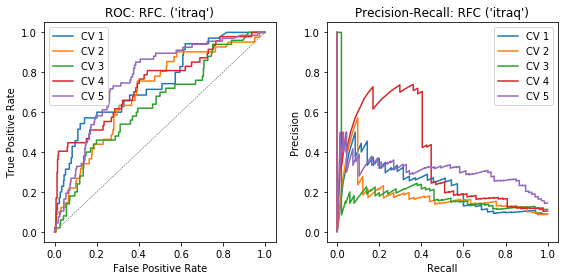

In [6]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=8)
initial_results = classifyCV(rfc, protocols_tfidf, df.label_free,
    name='RFC', n_splits=5, num_terms=22736)
summarize_results(initial_results, clf_label='RFC', target_label='itraq')

In [7]:
# Get number of non-zero features
rfc.n_features_, np.count_nonzero(rfc.feature_importances_)

(22736, 713)

In [21]:
pd.Series(rfc.feature_importances_).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    22736.000000
mean         0.000044
std          0.000342
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
95%          0.000000
99%          0.001534
max          0.013251
dtype: float64

In [22]:
X0 = matutils.corpus2dense(protocols_tfidf, num_terms=22736).T

new_inds1 = np.argwhere(rfc.feature_importances_ > 0).flatten()
new_inds2 = np.argwhere(rfc.feature_importances_ >= 0.0005).flatten()
new_inds3 = np.argwhere(rfc.feature_importances_ >= 0.001).flatten()
new_inds4 = np.argwhere(rfc.feature_importances_ >= 0.005).flatten()

X1 = X0[:, new_inds1]
X2 = X0[:, new_inds2]
X3 = X0[:, new_inds3]
X4 = X0[:, new_inds4]

print('Shape before:', X0.shape)
print('Shape X1   :', X1.shape)
print('Shape X2   :', X2.shape)
print('Shape X3   :', X3.shape)
print('Shape X3   :', X4.shape)

Shape before: (2387, 22736)
Shape X1   : (2387, 713)
Shape X2   : (2387, 566)
Shape X3   : (2387, 406)
Shape X3   : (2387, 18)


In [23]:
# Check fraction of spectrum_counting class
print('Fraction with label_free = %.2f%%' % (100*df.label_free.sum()/len(df)))

Fraction with label_free = 10.05%


##### With RFC

In [24]:
rfcX1 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
rfcX2 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
rfcX3 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
rfcX4 = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)

res_X1 = classifyCV(rfcX1, X1, df.label_free, name='RFC', n_splits=10, num_terms=22736)
res_X2 = classifyCV(rfcX2, X2, df.label_free, name='RFC', n_splits=10, num_terms=22736)
res_X3 = classifyCV(rfcX3, X2, df.label_free, name='RFC', n_splits=10, num_terms=22736)
res_X4 = classifyCV(rfcX4, X4, df.label_free, name='RFC', n_splits=10, num_terms=22736)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklea

========== RFC with X1 10-fold CV stats ==========
accuracy: 0.90 +/- 0.033
precision: 0.30 +/- 0.483
recall: 0.02 +/- 0.047
f1: 0.04 +/- 0.083
average_precision: 0.38 +/- 0.150
roc_auc: 0.80 +/- 0.058
Brier_loss: 0.08 +/- 0.025
========== RFC with X2 10-fold CV stats ==========
accuracy: 0.90 +/- 0.033
precision: 0.30 +/- 0.483
recall: 0.02 +/- 0.047
f1: 0.04 +/- 0.083
average_precision: 0.38 +/- 0.126
roc_auc: 0.79 +/- 0.070
Brier_loss: 0.08 +/- 0.025
========== RFC with X3 10-fold CV stats ==========
accuracy: 0.90 +/- 0.033
precision: 0.30 +/- 0.483
recall: 0.02 +/- 0.037
f1: 0.04 +/- 0.067
average_precision: 0.39 +/- 0.143
roc_auc: 0.80 +/- 0.062
Brier_loss: 0.08 +/- 0.025
========== RFC with X4 10-fold CV stats ==========
accuracy: 0.90 +/- 0.029
precision: 0.56 +/- 0.429
recall: 0.07 +/- 0.071
f1: 0.12 +/- 0.112
average_precision: 0.34 +/- 0.134
roc_auc: 0.76 +/- 0.068
Brier_loss: 0.08 +/- 0.023


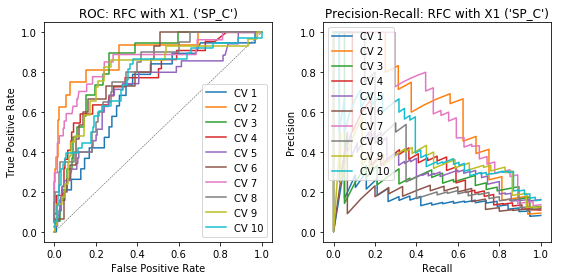

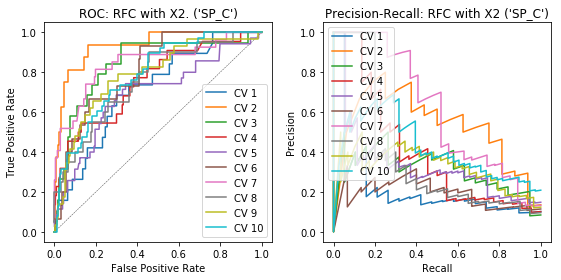

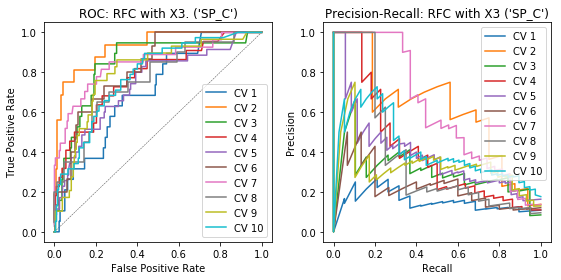

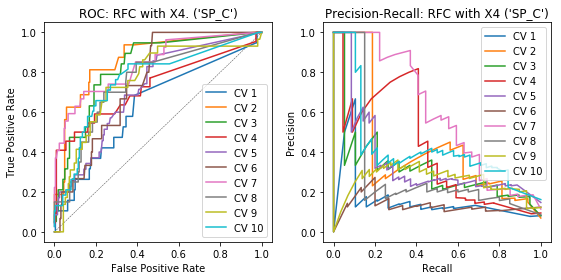

In [25]:
summarize_results(res_X1, clf_label='RFC with X1', target_label='SP_C', plot_result=True)
summarize_results(res_X2, clf_label='RFC with X2', target_label='SP_C', plot_result=True)
summarize_results(res_X3, clf_label='RFC with X3', target_label='SP_C', plot_result=True)
summarize_results(res_X4, clf_label='RFC with X4', target_label='SP_C', plot_result=True)

#### With LR

In [26]:
lrX1 = LogisticRegression(penalty='l1', C=10)
lrX2 = LogisticRegression(penalty='l1', C=10)
lrX3 = LogisticRegression(penalty='l1', C=10)
lrX4 = LogisticRegression(penalty='l1', C=10)

res_X1lr = classifyCV(lrX1, X1, df.label_free, name='LR', n_splits=10, num_terms=22736)
res_X2lr = classifyCV(lrX2, X2, df.label_free, name='LR', n_splits=10, num_terms=22736)
res_X3lr = classifyCV(lrX3, X3, df.label_free, name='LR', n_splits=10, num_terms=22736)
res_X4lr = classifyCV(lrX4, X4, df.label_free, name='LR', n_splits=10, num_terms=22736)

/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ryohayama/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


========== LR with X1 10-fold CV stats ==========
accuracy: 0.89 +/- 0.028
precision: 0.44 +/- 0.227
recall: 0.15 +/- 0.080
f1: 0.22 +/- 0.105
average_precision: 0.32 +/- 0.099
roc_auc: 0.78 +/- 0.073
Brier_loss: 0.09 +/- 0.023
========== LR with X2 10-fold CV stats ==========
accuracy: 0.89 +/- 0.034
precision: 0.43 +/- 0.163
recall: 0.15 +/- 0.063
f1: 0.22 +/- 0.078
average_precision: 0.35 +/- 0.100
roc_auc: 0.79 +/- 0.066
Brier_loss: 0.08 +/- 0.024
========== LR with X3 10-fold CV stats ==========
accuracy: 0.90 +/- 0.031
precision: 0.48 +/- 0.202
recall: 0.17 +/- 0.102
f1: 0.25 +/- 0.133
average_precision: 0.37 +/- 0.111
roc_auc: 0.80 +/- 0.067
Brier_loss: 0.08 +/- 0.022
========== LR with X4 10-fold CV stats ==========
accuracy: 0.90 +/- 0.030
precision: 0.45 +/- 0.405
recall: 0.07 +/- 0.066
f1: 0.11 +/- 0.099
average_precision: 0.29 +/- 0.099
roc_auc: 0.75 +/- 0.064
Brier_loss: 0.09 +/- 0.023


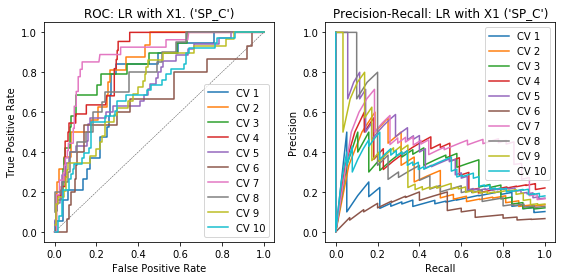

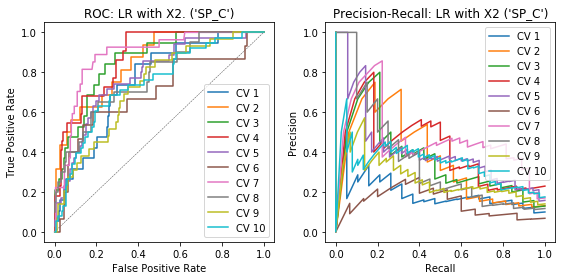

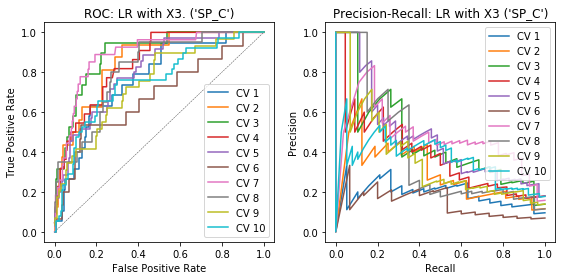

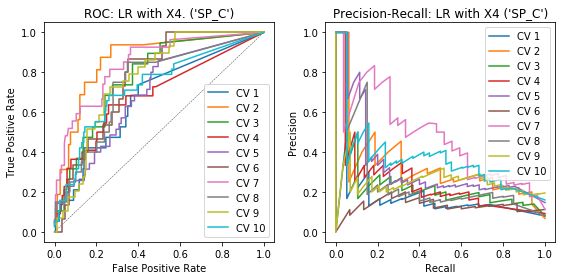

In [27]:
summarize_results(res_X1lr, clf_label='LR with X1', target_label='SP_C', plot_result=True)
summarize_results(res_X2lr, clf_label='LR with X2', target_label='SP_C', plot_result=True)
summarize_results(res_X3lr, clf_label='LR with X3', target_label='SP_C', plot_result=True)
summarize_results(res_X4lr, clf_label='LR with X4', target_label='SP_C', plot_result=True)

In [28]:
reverse_dict = {v:k for k, v in my_dictionary.token2id.items()}

In [30]:
inds_collection = [new_inds3, new_inds4]
for i, ind_set in enumerate(inds_collection):
    print('='*10, 'Feature Set %d' % (i+2),'='*10)
    for ind in ind_set:
        print(reverse_dict[ind])

========== Feature Set 2 ==========
analysis
difference
gene
itraq
ms
peptide
proteome
tissue
trypsin
acetic
acetone
acetonitrile
acn
acquisition
apply
area
bandelin
centrifugation
column
da
data
depend
desalt
electronic
extract
filter
final
germany
healthcare
identification
import
investigation
ions
lead
methionine
modification
modify
morganii
nanoelectrospray
nl
normalization
okuda
parameter
pellet
person
ppm
production
raw
receptor
reduce
scientific
setup
store
subsequently
technical
thereafter
time
tolerance
urinary
urine
usa
wash
collision
deviation
engine
ensure
fixed
fragmentation
free
generation
house
inhibit
method
rate
resolution
science
trigger
water
liquid
technology
throughput
yet
acidify
exactive
heavy
maxquant
minute
ontology
perseus
silac
statistical
andromeda
clinical
default
dionex
four
iaa
max
number
reproducibility
review
ripa
select
terminal
bira
feature
lfq
stagetips
welch
dynamics
map
sodium
desalting
electrospray
pak
site
appropriate
delay
mg
ns
part
plate
tof
v